# 2. Resnet 

### 2.1- The identity block


The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1).   Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.   
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read over this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [See reference](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [See reference](https://keras.io/layers/merge/#add)

In [4]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
#     from __future__ import print_function, division
#     from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tf_resnet_convblock import ConvLayer, BatchNormLayer

def conv2d(inputs, filters,kernel_size=[1,1], padding = 'valid', kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 0)):
  return tf.layers.conv2d(inputs = inputs, filters = filters, kernel_size = kernel_size, padding = padding, activation = None, kernel_initializer = kernel_initializer)


class IdentityBlock:
  def __init__(self, mi, feature_sizes):
    self.sess = None 
    self.input = tf.placeholder(tf.float32, shape=(1, 224, 224, mi))

    self.conv1 = conv2d(inputs = self.input, filters = feature_sizes[0])
    self.bn1 = tf.contrib.layers.batch_norm(inputs = self.conv1)
    self.relu1 = tf.nn.relu(self.bn1)

    self.conv2 = conv2d(inputs = self.relu1, filters = feature_sizes[1], kernel_size= [3,3], padding = 'same')
    self.bn2 = tf.contrib.layers.batch_norm(inputs = self.conv2)
    self.relu2 = tf.nn.relu(self.bn2)

    self.conv3 = conv2d(inputs = self.relu2, filters = feature_sizes[2])
    self.bn3 = tf.contrib.layers.batch_norm(inputs = self.conv3)

    self.output = tf.nn.relu(self.bn3 + self.input)



  def predict(self, X):
    assert (self.sess is not None)
    return self.sess.run(self.output, feed_dict ={self.input: X})



if __name__ == '__main__':
  identity_block = IdentityBlock(256,[64, 64, 256])

  # make a fake image
  X = np.random.random((1, 224, 224, 256))

  init = tf.global_variables_initializer()
  with tf.Session() as session:
    identity_block.sess = session
    session.run(init)

    output = identity_block.predict(X)
    print("output.shape:", output.shape)
    print("input.shape: ", X.shape)


output.shape: (1, 224, 224, 256)
input.shape:  (1, 224, 224, 256)


### 2.2 - The convolutional block

You've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Convolutional block** </center></caption>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s).  
- The first BatchNorm is normalizing the channels axis.  
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1).  
- The second BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1).  
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s)
- The BatchNorm is normalizing the channels axis.

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest. As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv Hint](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm Hint](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Addition Hint](https://keras.io/layers/merge/#add)

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#d: feature length, mi: num input feature map, mo: ...

class ConvBlock:
  def __init__(self, mi, fm_sizes, f):
    self.session = None

    #Weights
    self.W1 = tf.get_variable('W1',[1, 1, mi, fm_sizes[0]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.W2 = tf.get_variable('W2',[f, f, fm_sizes[0], fm_sizes[1]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.W3 = tf.get_variable('W3',[1, 1, fm_sizes[1], fm_sizes[2]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    self.Wf = tf.get_variable('Wf',[1, 1, mi, fm_sizes[2]],initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    #batch norm:
    self.mean1 = tf.Variable(np.zeros(fm_sizes[0], dtype=np.float32), trainable=False)
    self.mean2 = tf.Variable(np.zeros(fm_sizes[1], dtype=np.float32), trainable=False)
    self.mean3 = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32), trainable=False)
    self.meanf = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32), trainable=False)
    self.var1 = tf.Variable(np.ones(fm_sizes[0], dtype=np.float32), trainable=False)
    self.var2 = tf.Variable(np.ones(fm_sizes[1], dtype=np.float32), trainable=False)
    self.var3 = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32), trainable=False)
    self.varf = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32), trainable=False)
    self.gamma1        = tf.Variable(np.ones(fm_sizes[0], dtype=np.float32))
    self.gamma2        = tf.Variable(np.ones(fm_sizes[1], dtype=np.float32))
    self.gamma3        = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32))
    self.gammaf        = tf.Variable(np.ones(fm_sizes[2], dtype=np.float32))
    self.beta1         = tf.Variable(np.zeros(fm_sizes[0], dtype=np.float32))
    self.beta2         = tf.Variable(np.zeros(fm_sizes[1], dtype=np.float32))
    self.beta3         = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32))
    self.betaf         = tf.Variable(np.zeros(fm_sizes[2], dtype=np.float32))

    self.input = tf.placeholder(tf.float32, shape=(1, 224, 224, mi))
    self.output = self.forward(self.input)


  def forward(self,X):
    FX = tf.nn.conv2d(X, self.W1, strides=[1,1,1,1],padding = 'VALID')
    FX = tf.nn.batch_normalization(FX,self.mean1,self.var1,self.gamma1,self.beta1,1e-3)
    FX = tf.nn.relu(FX)

    FX = tf.nn.conv2d(FX, self.W2, strides=[1,1,1,1],padding = 'SAME')
    FX = tf.nn.batch_normalization(FX,self.mean2,self.var2,self.gamma2,self.beta2,1e-3)
    FX = tf.nn.relu(FX)

    FX = tf.nn.conv2d(FX, self.W3, strides=[1,1,1,1],padding = 'VALID')
    FX = tf.nn.batch_normalization(FX,self.mean3,self.var3,self.gamma3,self.beta3,1e-3)

    ##shortcut
    GX = tf.nn.conv2d(X, self.Wf, strides=[1,1,1,1],padding = 'VALID')
    GX = tf.nn.batch_normalization(GX,self.meanf,self.varf,self.gammaf,self.betaf,1e-3)
    return tf.nn.relu(FX+GX)

  def predict(self, X):
    assert(self.session is not None)
    return self.session.run(self.output, feed_dict={self.input: X})


if __name__ == '__main__':
  conv_block = ConvBlock(mi=3, fm_sizes=[64, 64, 256], f=3)


  # make a fake image
  X = np.random.random((1, 224, 224, 3))

  init = tf.global_variables_initializer()
  with tf.Session() as session:
    conv_block.session = session
    session.run(init)

    output = conv_block.predict(X)
    print("input.shape:", X.shape)
    print("output.shape:", output.shape)

/home/thunguyen/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


input.shape: (1, 224, 224, 3)
output.shape: (1, 224, 224, 256)


### 2.3 - Resnet full block

<img src="images/Resnet.png" style="width:350px;height:900px;transform:rotate(-90deg);" class="rotate90" >
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Resnet Model** </center></caption>

In [5]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future


# Let's go up to the end of the first conv block
# to make sure everything has been loaded correctly
# compared to keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense
from keras.applications.resnet50 import preprocess_input, decode_predictions

from tf_resnet_convblock import ConvLayer, BatchNormLayer, ConvBlock
from tf_resnet_identity_block import IdentityBlock
from tf_resnet_first_layers import ReLULayer, MaxPoolLayer


# NOTE: dependent on your Keras version
#       this script used 2.1.1
# [<keras.engine.topology.InputLayer at 0x112fe4358>,
#  <keras.layers.convolutional.Conv2D at 0x112fe46a0>,
#  <keras.layers.normalization.BatchNormalization at 0x112fe4630>,
#  <keras.layers.core.Activation at 0x112fe4eb8>,
#  <keras.layers.pooling.MaxPooling2D at 0x10ed4be48>,
#
#  ConvBlock
#  IdentityBlock x 2
#
#  ConvBlock
#  IdentityBlock x 3
#
#  ConvBlock
#  IdentityBlock x 5
#
#  ConvBlock
#  IdentityBlock x 2
#
#  AveragePooling2D
#  Flatten
#  Dense (Softmax)
# ]


# define some additional layers so they have a forward function
class AvgPool:
  def __init__(self, ksize):
    self.ksize = ksize

  def forward(self, X):
    return tf.nn.avg_pool(
      X,
      ksize=[1, self.ksize, self.ksize, 1],
      strides=[1, 1, 1, 1],
      padding='VALID'
    )

  def get_params(self):
    return []

class Flatten:
  def forward(self, X):
    return tf.contrib.layers.flatten(X)

  def get_params(self):
    return []


def custom_softmax(x):
  m = tf.reduce_max(x, 1)
  x = x - m
  e = tf.exp(x)
  return e / tf.reduce_sum(e, -1)


class DenseLayer:
  def __init__(self, mi, mo):
    self.W = tf.Variable((np.random.randn(mi, mo) * np.sqrt(2.0 / mi)).astype(np.float32))
    self.b = tf.Variable(np.zeros(mo, dtype=np.float32))

  def forward(self, X):
    # unfortunately these all yield slightly different answers
    # return tf.nn.softmax(tf.matmul(X, self.W) + self.b)
    # return custom_softmax(tf.matmul(X, self.W) + self.b)
    # return keras.activations.softmax(tf.matmul(X, self.W) + self.b)
    return tf.matmul(X, self.W) + self.b

  def copyFromKerasLayers(self, layer):
    W, b = layer.get_weights()
    op1 = self.W.assign(W)
    op2 = self.b.assign(b)
    self.session.run((op1, op2))

  def get_params(self):
    return [self.W, self.b]


class TFResNet:
  def __init__(self):
    self.layers = [
      # before conv block
      ConvLayer(d=7, mi=3, mo=64, stride=2, padding='SAME'),
      BatchNormLayer(64),
      ReLULayer(),
      MaxPoolLayer(dim=3),
      # conv block
      ConvBlock(mi=64, fm_sizes=[64, 64, 256], stride=1),
      # identity block x 2
      IdentityBlock(mi=256, fm_sizes=[64, 64, 256]),
      IdentityBlock(mi=256, fm_sizes=[64, 64, 256]),
      # conv block
      ConvBlock(mi=256, fm_sizes=[128, 128, 512], stride=2),
      # identity block x 3
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      IdentityBlock(mi=512, fm_sizes=[128, 128, 512]),
      # conv block
      ConvBlock(mi=512, fm_sizes=[256, 256, 1024], stride=2),
      # identity block x 5
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      IdentityBlock(mi=1024, fm_sizes=[256, 256, 1024]),
      # conv block
      ConvBlock(mi=1024, fm_sizes=[512, 512, 2048], stride=2),
      # identity block x 2
      IdentityBlock(mi=2048, fm_sizes=[512, 512, 2048]),
      IdentityBlock(mi=2048, fm_sizes=[512, 512, 2048]),
      # pool / flatten / dense
      AvgPool(ksize=7),
      Flatten(),
      DenseLayer(mi=2048, mo=1000)
    ]
    self.input_ = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
    self.output = self.forward(self.input_)

  def copyFromKerasLayers(self, layers):
    # conv
    self.layers[0].copyFromKerasLayers(layers[1])
    # bn
    self.layers[1].copyFromKerasLayers(layers[2])
    # cb
    self.layers[4].copyFromKerasLayers(layers[5:17]) # size=12
    # ib x 2
    self.layers[5].copyFromKerasLayers(layers[17:27]) # size=10
    self.layers[6].copyFromKerasLayers(layers[27:37])
    # cb
    self.layers[7].copyFromKerasLayers(layers[37:49])
    # ib x 3
    self.layers[8].copyFromKerasLayers(layers[49:59])
    self.layers[9].copyFromKerasLayers(layers[59:69])
    self.layers[10].copyFromKerasLayers(layers[69:79])
    # cb
    self.layers[11].copyFromKerasLayers(layers[79:91])
    # ib x 5
    self.layers[12].copyFromKerasLayers(layers[91:101])
    self.layers[13].copyFromKerasLayers(layers[101:111])
    self.layers[14].copyFromKerasLayers(layers[111:121])
    self.layers[15].copyFromKerasLayers(layers[121:131])
    self.layers[16].copyFromKerasLayers(layers[131:141])
    # cb
    self.layers[17].copyFromKerasLayers(layers[141:153])
    # ib x 2
    self.layers[18].copyFromKerasLayers(layers[153:163])
    self.layers[19].copyFromKerasLayers(layers[163:173])
    # dense
    self.layers[22].copyFromKerasLayers(layers[175])


  def forward(self, X):
    for layer in self.layers:
      X = layer.forward(X)
    return X

  def predict(self, X):
    assert(self.session is not None)
    return self.session.run(
      self.output,
      feed_dict={self.input_: X}
    )

  def set_session(self, session):
    self.session = session
    for layer in self.layers:
      if isinstance(layer, ConvBlock) or isinstance(layer, IdentityBlock):
        layer.set_session(session)
      else:
        layer.session = session

  def get_params(self):
    params = []
    for layer in self.layers:
      params += layer.get_params()


if __name__ == '__main__':
  # you can also set weights to None, it doesn't matter
  resnet_ = ResNet50(weights='imagenet')

  # make a new resnet without the softmax
  x = resnet_.layers[-2].output
  W, b = resnet_.layers[-1].get_weights()
  y = Dense(1000)(x)
  resnet = Model(resnet_.input, y)
  resnet.layers[-1].set_weights([W, b])
 

  # you can determine the correct layer
  # by looking at resnet.layers in the console
  partial_model = Model(
    inputs=resnet.input,
    outputs=resnet.layers[175].output
  )

  # maybe useful when building your model
  # to look at the layers you're trying to copy
  print(partial_model.summary())

  # create an instance of our own model
  my_partial_resnet = TFResNet()

  # make a fake image
  X = np.random.random((1, 224, 224, 3))

  # get keras output
  keras_output = partial_model.predict(X)

  ### get my model output ###

  # init only the variables in our net
  init = tf.variables_initializer(my_partial_resnet.get_params())

  # note: starting a new session messes up the Keras model
  session = keras.backend.get_session()
  my_partial_resnet.set_session(session)
  session.run(init)

  # first, just make sure we can get any output
  first_output = my_partial_resnet.predict(X)
  print("first_output.shape:", first_output.shape)

  # copy params from Keras model
  my_partial_resnet.copyFromKerasLayers(partial_model.layers)

  # compare the 2 models
  output = my_partial_resnet.predict(X)
  diff = np.abs(output - keras_output).sum()
  if diff < 1e-10:
    print("Everything's great!")
  else:
    print("diff = %s" % diff)


102858752/102853048 [==============================] - 27s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
_________________________________________

### 2.4.1 - Resnet train in blood_cells data

4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_pool

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 150.94601


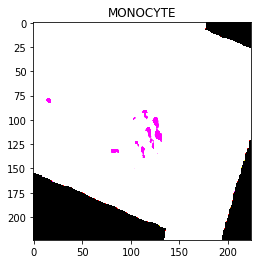

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/16
311/311 [==============================] - 252s 812ms/step - loss: 0.9484 - acc: 0.6050 - val_loss: 2.1865 - val_acc: 0.3705
Epoch 2/16
311/311 [==============================] - 245s 787ms/step - loss: 0.6390 - acc: 0.7525 - val_loss: 3.6472 - val_acc: 0.3161
Epoch 3/16
311/311 [==============================] - 248s 799ms/step - loss: 0.5466 - acc: 0.7889 - val_loss: 3.1266 - val_acc: 0.3536
Epoch 4/16
311/311 [==============================] - 236s 758ms/step - loss: 0.4863 - acc: 0.8172 - val_loss: 3.0666 - val_acc: 0.3475
Epoch 5/16
311/311 [==============================] - 237s 761ms/step - loss: 0.4380 - acc: 0.8369 - val_loss: 3.8002 - val_acc: 0.3442
Epoch 6/16
311/311 [==============================] - 253s 813ms/step - loss: 0.4163 - acc: 0.8407 - val_loss: 3.9663 - val_acc: 0.3426
Epoch 7/16
311/311 [==============================] - 252s 811ms/step - loss: 0.3917 - acc: 0.8503 -

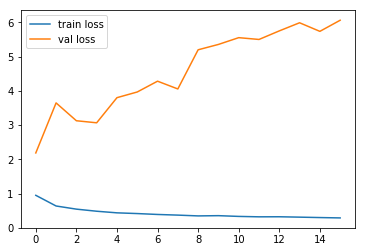

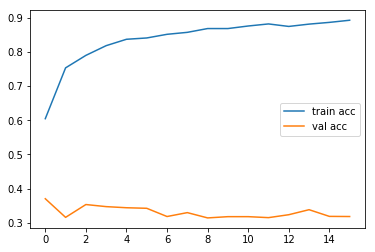

Confusion matrix, without normalization
[[   1  261 2234    1]
 [   0  780 1702    1]
 [   0   87 2391    0]
 [   1  222 2268    8]]


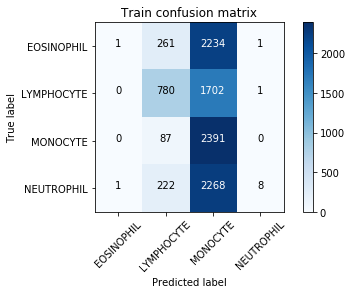

Confusion matrix, without normalization
[[  1 102 519   1]
 [  0 191 429   0]
 [  0   9 611   0]
 [  0  59 563   2]]


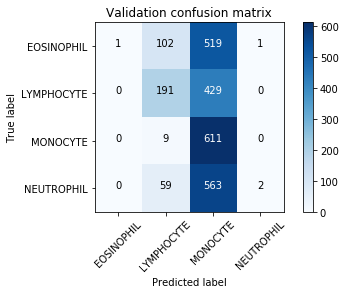

In [4]:

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = '../large_files/blood_cell_images/TRAIN'
valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
# train_path = '../large_files/fruits-360-small/Training'
# valid_path = '../large_files/fruits-360-small/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print(len(folders))
# look at an image for fun
# plt.imshow(image.load_img(np.random.choice(image_files)))
# plt.show()


# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

### 2.4.2 - Restnet in Fruit dataset

5


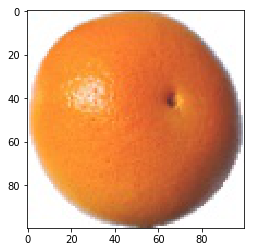

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -84.939 max: 151.061


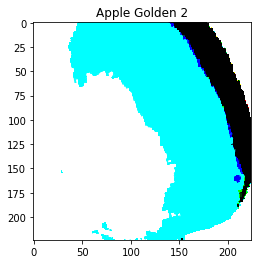

Found 29228 images belonging to 60 classes.
Found 9837 images belonging to 60 classes.
Epoch 1/5
913/913 [==============================] - 413s 453ms/step - loss: 0.2482 - acc: 0.9442 - val_loss: 1.7204 - val_acc: 0.6242
Epoch 2/5
913/913 [==============================] - 394s 432ms/step - loss: 0.0207 - acc: 0.9937 - val_loss: 1.8614 - val_acc: 0.6417
Epoch 3/5
913/913 [==============================] - 431s 472ms/step - loss: 0.0131 - acc: 0.9959 - val_loss: 1.6600 - val_acc: 0.6869
Epoch 4/5
913/913 [==============================] - 437s 478ms/step - loss: 0.0093 - acc: 0.9972 - val_loss: 1.8919 - val_acc: 0.6792
Epoch 5/5
913/913 [==============================] - 418s 457ms/step - loss: 0.0079 - acc: 0.9975 - val_loss: 2.1025 - val_acc: 0.6842
Generating confusion matrix 29228
Found 29228 images belonging to 60 classes.
50
100
150
200
250
300
350
400
450
[[453   0   0 ...   0   0   0]
 [  0 438  49 ...   0   0   0]
 [  0   0 492 ...   0   0   0]
 ...
 [  0   0   0 ... 471   0  

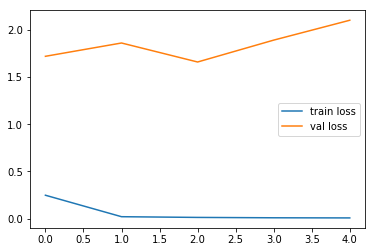

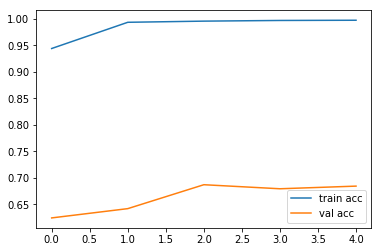

Confusion matrix, without normalization
[[453   0   0 ...   0   0   0]
 [  0 438  49 ...   0   0   0]
 [  0   0 492 ...   0   0   0]
 ...
 [  0   0   0 ... 471   0   0]
 [  0   0   0 ...   0 487   0]
 [  2   0   0 ...   0   0 262]]


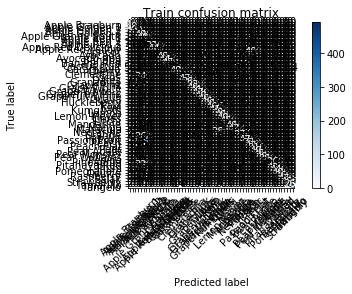

Confusion matrix, without normalization
[[162   0   0 ...   0   0   0]
 [  0 146  16 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 162   0   0]
 [  0   0   0 ...   0 163   0]
 [  1   0   0 ...   0   0  87]]


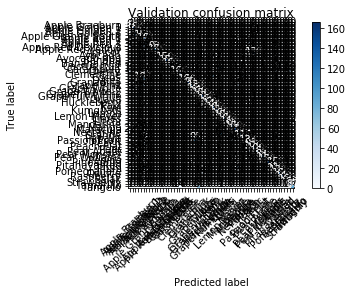

In [11]:
print(5)
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [224, 224]
epochs = 5
batch_size = 32


# https://www.kaggle.com/moltean/fruits
train_path = '../large_files/fruits-360/Training'
valid_path = '../large_files/fruits-360/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()


# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
### 2.4. Resnet train in blood_cells data